In [34]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score


import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers



In [2]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
display(data)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [3]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)
# label_df =pd.DataFrame(label)
# label_df.set_index('Date', inplace=True)
# display(type(label_df))

In [4]:

def create_X_y_rolling(df, target_label, window_size):
    X, y, labels, first_values = [], [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        first_value = window.iloc[0]
        normalized_window = window / first_value  
        X.append(normalized_window.values)
        
        y_target = df.iloc[i+window_size] / first_value  
        y.append(y_target.values)
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
        
        first_values.append(first_value.values) 
        
    X = np.array(X)
    y = np.array(y)
    first_values = np.array(first_values)
    labels = np.array(labels)
    return X, y, first_values, labels

window_size = 30
X, y, first_values, labels = create_X_y_rolling(data, binary_targets, window_size)
labels.shape, X.shape, y.shape, first_values.shape, len(labels)


((3378, 33), (3378, 30, 33), (3378, 33), (3378, 33), 3378)

In [5]:
dataset_size = len(X)
print(dataset_size)


train_size = int(dataset_size * 0.8)
test_size =int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size


X_train, X_val, X_test = X[:train_size], X[train_size: train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test= y[:train_size], y[train_size: train_size + val_size], y[train_size + val_size:]
labels_train, labels_val, labels_test = labels[:train_size], labels[train_size: train_size + val_size], labels[train_size + val_size:]


first_values_test = first_values[train_size + val_size:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape


3378


((2702, 30, 33),
 (2702, 33),
 (339, 30, 33),
 (339, 33),
 (337, 30, 33),
 (337, 33))

In [6]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), 

    LSTM(64, return_sequences=False, activation='linear'),
    Dropout(0.2),  

    Dense(y_train.shape[1] )
])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

cp = ModelCheckpoint(filepath='model_regression/best_LSTM.keras', save_best_only=True, monitor='val_loss', mode='min')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp, es],
)
# model.summary()



c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.3476 - mean_squared_error: 0.3474 - val_loss: 0.0110 - val_mean_squared_error: 0.0116
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - val_loss: 0.0046 - val_mean_squared_error: 0.0048
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0057 - val_mean_squared_error: 0.0061
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.0329 - mean_squared_error: 0.0328 - val_loss: 0.0041 - val_mean_squared_error: 0.0042
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - val_loss: 0.0041 - val_mean_squared_error: 0.0040
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0

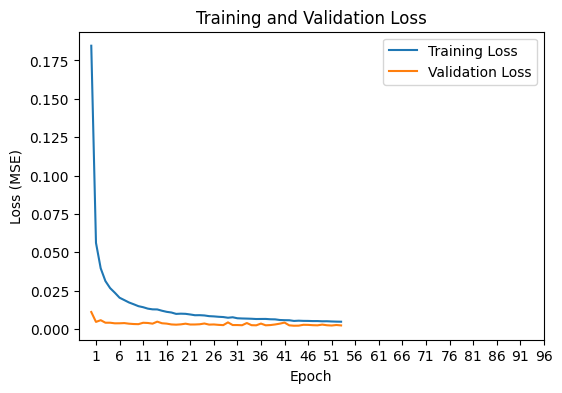

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 100, 5)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model = load_model('model_regression/best_LSTM.keras')
index_series = data.index[-len(y_test):]  # Use the last indices for the test set

Y_pred = model.predict(X_test)
Y_pred_denorm = Y_pred * first_values_test  

Predict_result_df = pd.DataFrame(Y_pred_denorm, index=index_series, columns=data.columns)

display(Predict_result_df)

# Predict_result_df["SPY"].plot()


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,31.433140,9.283785,67.785137,21.776367,14.790515,104.491228,50.144757,20.836898,31.801917,26.629527,...,23.036233,441.821371,84.162064,67.767242,119.326494,107.246798,57.937325,75.175386,64.608416,6.344913
2023-12-08,31.679539,9.327674,68.998235,21.889476,15.223605,105.498788,50.504055,20.899021,31.454378,26.868874,...,23.350992,444.588518,84.695235,66.873947,117.889833,107.751426,58.082419,74.679628,65.325438,6.398182
2023-12-11,31.514837,9.246935,68.926927,21.879644,14.487193,106.276782,50.681525,20.910575,31.593795,26.872124,...,23.269947,446.397836,84.325564,65.946688,117.303856,106.971598,58.321655,74.599918,65.215435,6.323988
2023-12-12,31.771411,9.166427,69.769238,21.913654,14.382024,107.069563,50.378258,20.901808,31.554060,26.920827,...,23.143421,448.821872,83.775253,65.886818,117.671537,107.779082,58.324282,75.867051,65.647681,6.324768
2023-12-13,31.931826,9.118358,69.925269,21.874161,14.258392,106.605530,50.849300,21.186844,31.750749,27.000857,...,23.037009,452.387600,85.280089,65.362792,117.586132,108.278481,58.533032,75.894906,66.385590,6.333635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,40.899165,10.928352,110.499177,19.511718,14.023909,108.927565,56.658718,25.483934,42.308208,35.408511,...,29.921096,608.903920,86.439307,73.913858,125.157713,146.951189,69.565104,91.443688,75.056704,7.665458
2025-03-25,40.536235,10.987817,109.407334,19.357050,14.096873,110.173887,56.438311,25.429946,42.335110,35.834089,...,29.862031,608.590231,86.119151,74.219739,125.509423,146.946544,69.985712,91.938235,75.054508,7.665450
2025-03-26,40.446495,10.986431,108.673650,19.569857,13.915370,109.402634,56.312893,25.643546,42.281584,36.125693,...,30.028248,604.874694,84.847060,73.874516,123.686278,146.036861,70.244313,90.696863,74.330730,7.646590


In [22]:
Y_pred

array([[1.1114335 , 1.0244528 , 1.148998  , ..., 1.1038855 , 1.0719191 ,
        1.0524426 ],
       [1.1284637 , 1.0234022 , 1.1708508 , ..., 1.1144595 , 1.0797445 ,
        1.0523326 ],
       [1.1222    , 1.0031896 , 1.168055  , ..., 1.106283  , 1.0674026 ,
        1.0401297 ],
       ...,
       [0.98374057, 1.0663172 , 0.96154356, ..., 1.0053604 , 1.0191799 ,
        1.0260437 ],
       [0.9745171 , 1.0703613 , 0.9493896 , ..., 0.9986402 , 1.0148655 ,
        1.022455  ],
       [0.9736103 , 1.0534967 , 0.95506245, ..., 0.99599934, 1.0138707 ,
        1.0225139 ]], dtype=float32)

In [38]:
# SUMMARY
y_test_denorm = y_test * first_values_test
y_actual = pd.DataFrame(y_test_denorm, index=index_series, columns=data.columns)


mae = mean_absolute_error(y_test, Y_pred)
mse = mean_squared_error(y_test, Y_pred)
rmse = np.sqrt(mse)


print("Mean Absolute Error for not normalized:", mae)
print("Mean Squared Error for not normalized:", mse)
print("Root Mean Squared Error for not normalized:", rmse)

r2 = r2_score(y_test, Y_pred)
r2_denorm = r2_score(y_test_denorm, Y_pred_denorm)
print("R² Score (normalized):", r2)
print("R² Score (denormalized):", r2_denorm)



Mean Absolute Error for not normalized: 0.03343400997390979
Mean Squared Error for not normalized: 0.0020408314761750147
Root Mean Squared Error for not normalized: 0.04517556282078857
R² Score (normalized): 0.3801549831468767
R² Score (denormalized): 0.4593343140735869


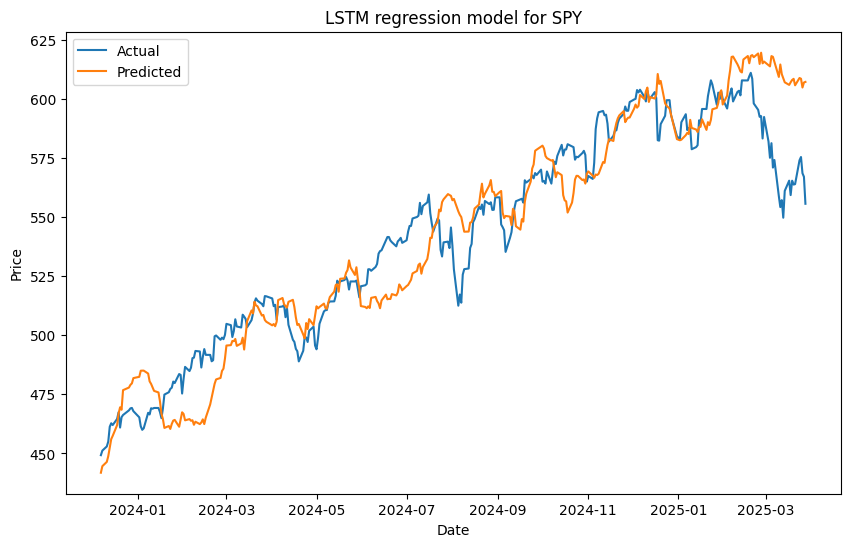

In [ ]:
ticker_name = 'SPY'
plt.figure(figsize=(10,6))
plt.plot(y_actual[ticker_name], label='Actual')
plt.plot(Predict_result_df[ticker_name], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'LSTM regression model for {ticker_name}')
plt.legend()
plt.show()

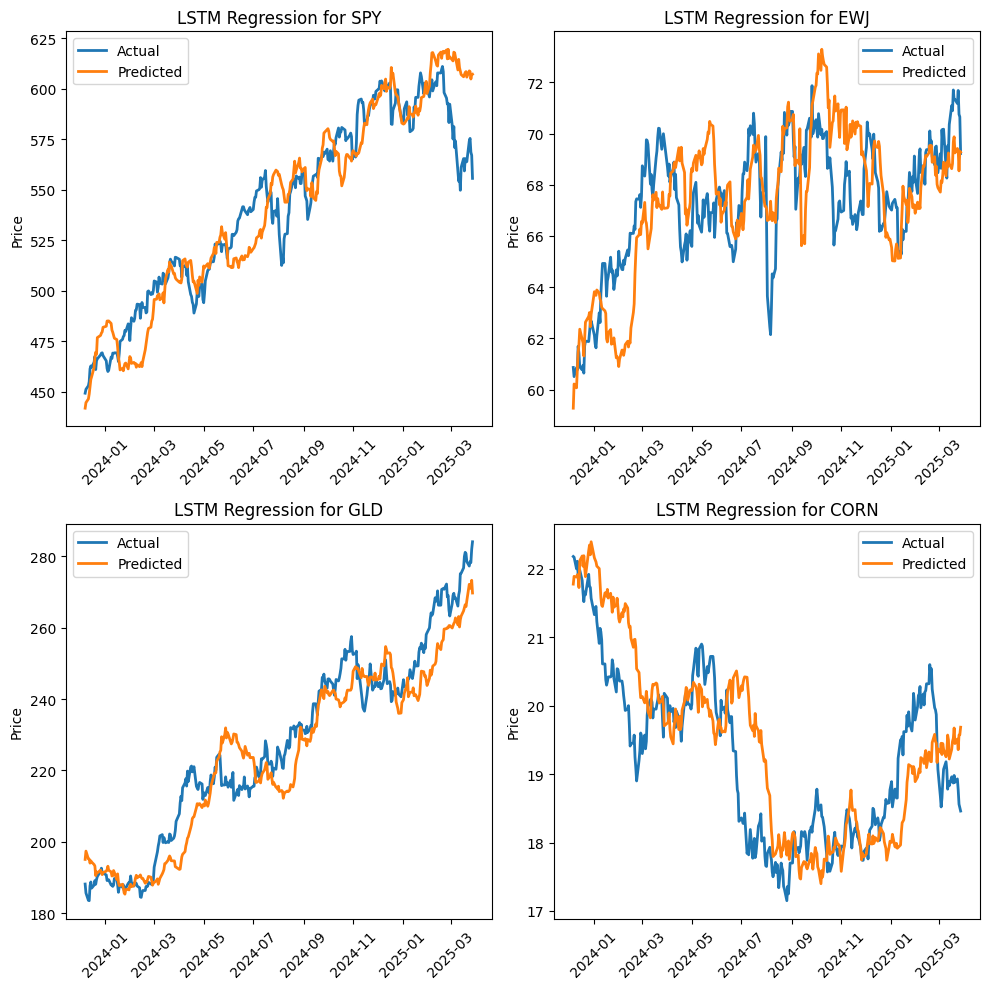

In [10]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  

num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten() 


for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Predict_result_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [ ]:
data

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [12]:
labels_test_df = pd.DataFrame(labels_test, index=index_series, columns=data.columns)
labels_test_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,1,1,0,1,1,1,1,1,0,1,...,0,1,0,1,0,0,1,1,1,0
2023-12-08,1,0,1,0,1,0,0,1,1,1,...,0,1,0,1,1,1,1,0,0,0
2023-12-11,1,1,0,0,1,0,1,0,1,1,...,0,1,0,1,1,1,1,1,1,1
2023-12-12,0,0,1,1,0,0,0,1,0,1,...,0,1,1,0,0,1,1,0,1,0
2023-12-13,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [13]:
display(labels_test_df["SPY"])

Date
2023-12-07    1
2023-12-08    1
2023-12-11    1
2023-12-12    1
2023-12-13    1
             ..
2025-03-24    1
2025-03-25    1
2025-03-26    0
2025-03-27    0
2025-03-28    0
Name: SPY, Length: 337, dtype: int64

In [14]:
Predict_result_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,31.433140,9.283785,67.785137,21.776367,14.790515,104.491228,50.144757,20.836898,31.801917,26.629527,...,23.036233,441.821371,84.162064,67.767242,119.326494,107.246798,57.937325,75.175386,64.608416,6.344913
2023-12-08,31.679539,9.327674,68.998235,21.889476,15.223605,105.498788,50.504055,20.899021,31.454378,26.868874,...,23.350992,444.588518,84.695235,66.873947,117.889833,107.751426,58.082419,74.679628,65.325438,6.398182
2023-12-11,31.514837,9.246935,68.926927,21.879644,14.487193,106.276782,50.681525,20.910575,31.593795,26.872124,...,23.269947,446.397836,84.325564,65.946688,117.303856,106.971598,58.321655,74.599918,65.215435,6.323988
2023-12-12,31.771411,9.166427,69.769238,21.913654,14.382024,107.069563,50.378258,20.901808,31.554060,26.920827,...,23.143421,448.821872,83.775253,65.886818,117.671537,107.779082,58.324282,75.867051,65.647681,6.324768
2023-12-13,31.931826,9.118358,69.925269,21.874161,14.258392,106.605530,50.849300,21.186844,31.750749,27.000857,...,23.037009,452.387600,85.280089,65.362792,117.586132,108.278481,58.533032,75.894906,66.385590,6.333635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,40.899165,10.928352,110.499177,19.511718,14.023909,108.927565,56.658718,25.483934,42.308208,35.408511,...,29.921096,608.903920,86.439307,73.913858,125.157713,146.951189,69.565104,91.443688,75.056704,7.665458
2025-03-25,40.536235,10.987817,109.407334,19.357050,14.096873,110.173887,56.438311,25.429946,42.335110,35.834089,...,29.862031,608.590231,86.119151,74.219739,125.509423,146.946544,69.985712,91.938235,75.054508,7.665450
2025-03-26,40.446495,10.986431,108.673650,19.569857,13.915370,109.402634,56.312893,25.643546,42.281584,36.125693,...,30.028248,604.874694,84.847060,73.874516,123.686278,146.036861,70.244313,90.696863,74.330730,7.646590


In [15]:
y_test_shift = data[-len(y_test) - 1: -1]
y_test_shift_index = data.index[-len(y_test) - 1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_denorm > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
display(predicted_directions_df)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2023-12-07,0,1,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
2023-12-08,0,1,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,0,0,0,0
2023-12-11,0,1,0,0,1,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2023-12-12,0,1,0,0,1,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2023-12-13,0,1,0,0,1,1,0,0,0,0,...,1,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,0,1,0,1,1,0
2025-03-25,1,1,1,1,0,1,0,1,1,0,...,0,1,0,0,0,1,0,1,1,0
2025-03-26,1,1,1,1,0,1,0,1,1,0,...,0,1,0,0,0,1,0,1,0,0


In [16]:
actual_flat = labels_test_df.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

matches = np.sum(actual_flat == predicted_flat)
percentage = (matches / len(actual_flat)) * 100
print(f"Match Percentage: {percentage:.2f}%")

accuracy = accuracy_score(actual_flat, predicted_flat)
print(f'Accuracy of the model: {accuracy:.4f}')

Match Percentage: 51.35%
Accuracy of the model: 0.5135


In [17]:
yesterday_prices = data.iloc[-2]  
today_prices_actual = data.iloc[-1] 
Y_pred_mean = Y_pred_denorm.mean(axis=0)
today_prices_predicted = pd.Series(Y_pred_mean.flatten(), index=data.columns)
comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_pred': today_prices_predicted,
})
tickers_names = data.columns
correct_list = []
for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]
    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)
    if sign_actual == sign_pred:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list
count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
display(comparison_df)
# save_df = pd.DataFrame()
# save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
# save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
# save_df['Today pred target'] = comparison_df['Today_pred'].apply(lambda x: round(x, 2))
# save_df['Correct'] = comparison_df['Correct']
# display(save_df)
# save_df.to_csv('rnn_regression.csv', index=True)


Count of correct predictions: 23
accuracy: 0.696969696969697


,Yesterday_actual,Today_actual,Today_pred,Correct
AIEQ,37.658001,36.845001,37.257606,1
ASHR.L,10.460000,10.340000,9.549652,1
BCHN.L,97.080002,92.714996,96.149885,1
CORN,18.510000,18.459999,19.428154,0
DBO,14.130000,13.970000,14.109084,1
EDEN,105.330002,105.169998,120.329903,0
EMXC,56.110001,55.180000,56.614568,0
EWA,23.750000,23.469999,24.352136,0
EWC,41.250000,40.570000,38.310820,1
EWG,37.590000,37.389999,31.420675,1
